In [1]:
import numpy as np
import g3utils as ut
import matplotlib.pyplot as plt
import so3g.proj
from spt3g import core
import pathlib

In [2]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

ra_df_added = control_computer_g3_dir / "mapmaking/ra_df_added.g3"
norm_df_added = control_computer_g3_dir / "mapmaking/norm_df_added.g3"

In [33]:
# create non-normalized df and compute stats

stats = ut.DetectorStats(data_key="df")
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.AddScanDF)
pipe.Add(stats)
pipe.Add(ut.FrameCounter)
pipe.Run()
# see signal_analysis.ipynb for plots of this data
detector_medians = np.median(np.array(stats.medians), axis=0)
detector_stds = np.median(np.array(stats.stds), axis=0)


Calibration
PipelineInfo
Scan (x117)
EndProcessing


In [34]:
# Uncomment this pipeline to recompute & overwrite ra_df_added/norm_df_added

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.add_radec_so3g)
pipe.Add(ut.AddScanDF)
pipe.Add(ut.add_cal_lamp_df, iq_key="cal_lamp_data")
pipe.Add(core.G3Writer, filename=str(ra_df_added))
pipe.Add(ut.NormalizeDF, detector_medians=detector_medians)
pipe.Add(core.G3Writer, filename=str(norm_df_added))
pipe.Add(ut.FrameCounter)
pipe.Run()

"""
Pipeline profiling results:
spt3g.core.G3Reader: 0.071389 user, 0.037763 system, 120 frames (0.000910 s per input frame)
_pipelineinfo: 0.000000 user, 0.000000 system, 120 frames (0.000000 s per input frame)
g3utils.add_radec_so3g: 0.197547 user, 0.000434 system, 120 frames (0.001650 s per input frame)
g3utils.AddScanDF: 25.434544 user, 0.064807 system, 120 frames (0.212495 s per input frame)
g3utils.add_cal_lamp_df: 0.281990 user, 0.009692 system, 120 frames (0.002431 s per input frame)
g3utils.NormalizeDF: 0.253910 user, 0.000002 system, 120 frames (0.002116 s per input frame)
g3utils.FrameCounter: 0.003378 user, 0.000064 system, 120 frames (0.000029 s per input frame)
spt3g.core.G3Writer: 3.151443 user, 0.251032 system, 120 frames (0.028354 s per input frame)
Total: 29.394201 user, 0.363794 system
Peak memory consumption (369.4 MB) in module g3utils.add_cal_lamp_df
""";


Calibration
PipelineInfo
Scan (x117)
EndProcessing


In [14]:
def first_frame(file, type=core.G3FrameType.Scan):
    grabber = ut.FirstFrameGrabber(frame_type=type)
    pipe = core.G3Pipeline()
    pipe.Add(core.G3Reader, filename=file)
    pipe.Add(grabber)
    pipe.Run()
    return grabber.first_frame

kids: np.ndarray[str] = np.array(first_frame(str(norm_df_added))["norm_df"].names)
kids.sort()

In [20]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

# map dimensions
xlen = 1.4 * core.G3Units.deg
ylen = 0.9 * core.G3Units.deg

# pixel resolution
res = 1 * core.G3Units.arcmin

source_coords = {}
# determine source shifts
binners = [
    ut.SingleMapBinner(
        kid,
        timestreams="df",
        ra0=ra0,
        dec0=dec0,
        xlen=xlen,
        ylen=ylen,
        res=res
    ) for kid in kids
]

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
for binner in binners:
    pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

for kid, binner in zip(kids, binners):
    source_coords[kid] = binner.source_coords()

source_coords


Calibration
PipelineInfo
Scan (x117)
EndProcessing


{np.str_('roach1_0000'): (np.int64(50), np.int64(30)),
 np.str_('roach1_0001'): (np.int64(32), np.int64(24)),
 np.str_('roach1_0002'): (np.int64(66), np.int64(16)),
 np.str_('roach1_0003'): (np.int64(40), np.int64(11)),
 np.str_('roach1_0004'): (np.int64(57), np.int64(29)),
 np.str_('roach1_0005'): (np.int64(67), np.int64(20)),
 np.str_('roach1_0006'): (np.int64(35), np.int64(27)),
 np.str_('roach1_0007'): (np.int64(62), np.int64(27)),
 np.str_('roach1_0008'): (np.int64(66), np.int64(18)),
 np.str_('roach1_0009'): (np.int64(29), np.int64(20)),
 np.str_('roach1_0010'): (np.int64(36), np.int64(13)),
 np.str_('roach1_0011'): (np.int64(16), np.int64(16)),
 np.str_('roach1_0012'): (np.int64(65), np.int64(27)),
 np.str_('roach1_0013'): (np.int64(32), np.int64(16)),
 np.str_('roach1_0014'): (np.int64(59), np.int64(28)),
 np.str_('roach1_0015'): (np.int64(31), np.int64(22)),
 np.str_('roach1_0016'): (np.int64(50), np.int64(10)),
 np.str_('roach1_0017'): (np.int64(60), np.int64(13)),
 np.str_('

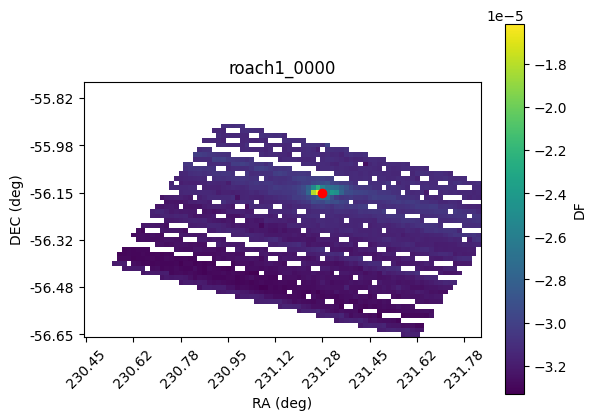

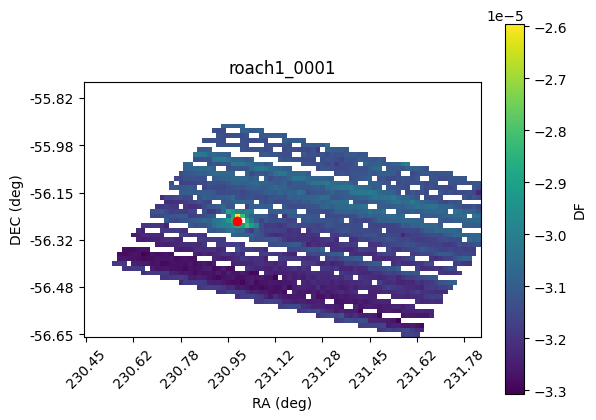

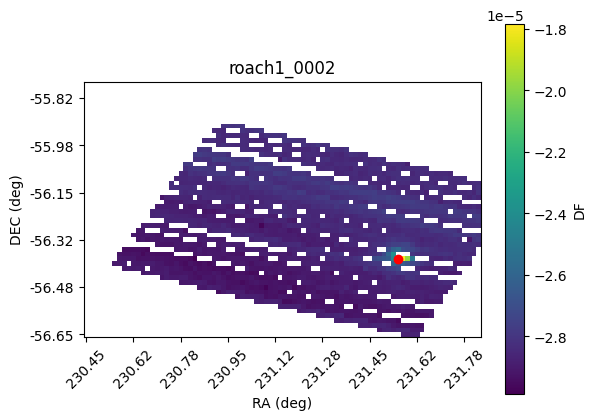

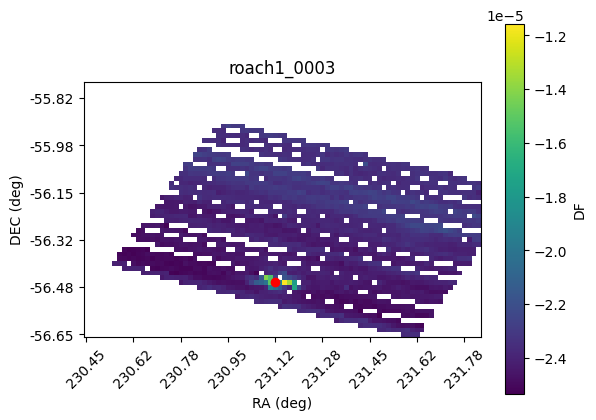

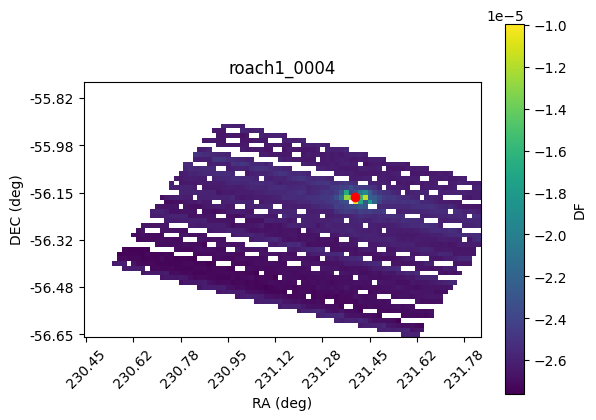

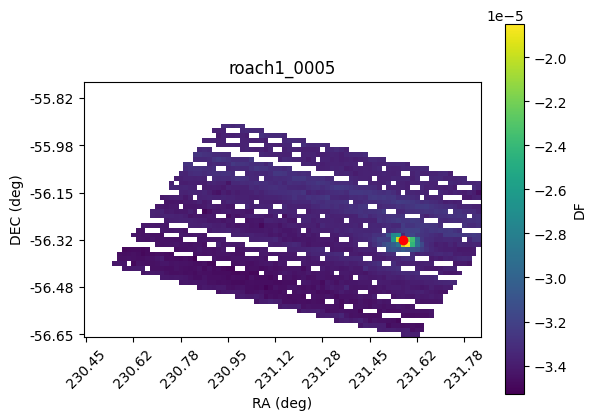

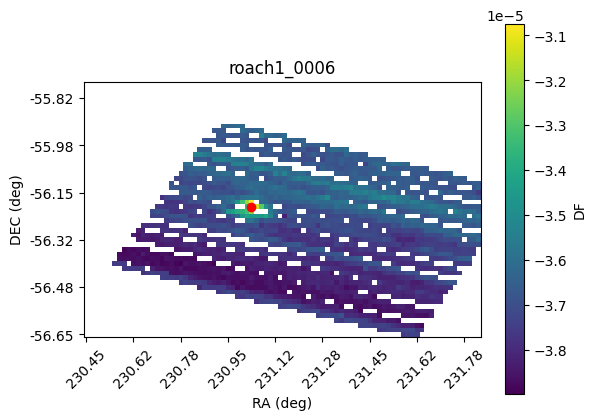

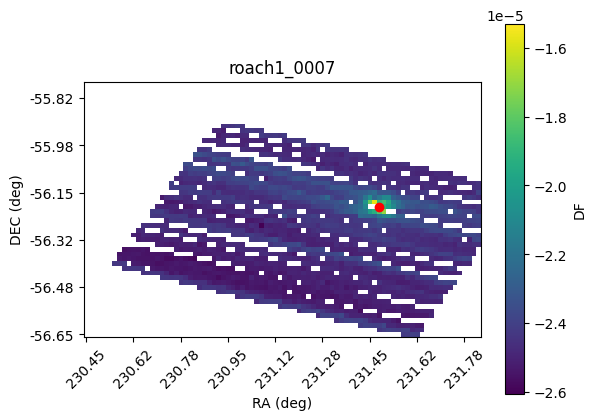

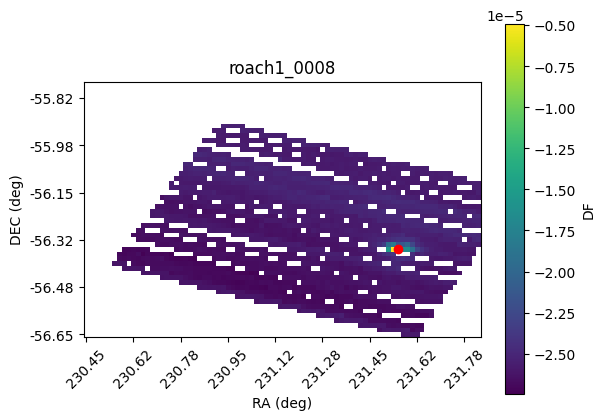

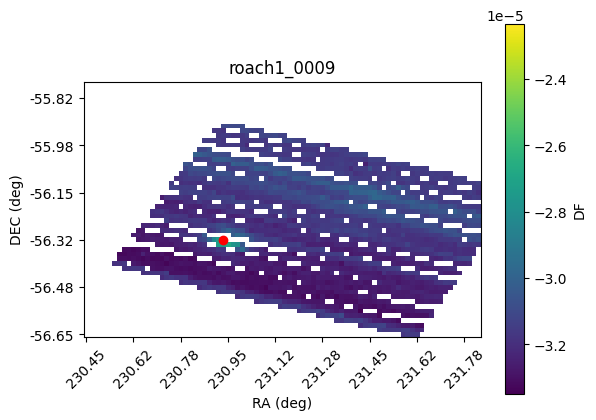

In [22]:
for i in range(10):
    binners[i].plot()

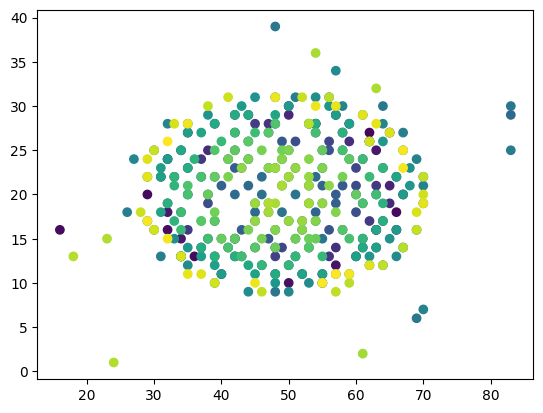

In [25]:
xs=[]
ys=[]
for key in source_coords.keys():# for binner in binners:
#     binner.plot()
    xs.append(source_coords[key][0])
    ys.append(source_coords[key][1])
plt.scatter(xs, ys, c=range(len(xs)))

In [26]:
rcw_92_min_lat = -77.110
rcw_92_max_lat = -77.070
rcw_92_min_lon = 162.20
rcw_92_max_lon = 162.55
rcw_92_min_alt = 36030
rcw_92_max_alt = 36120
rcw_92_avg_lat = rcw_92_min_lat / 2. + rcw_92_max_lat / 2.
rcw_92_avg_lon = rcw_92_min_lon / 2. + rcw_92_max_lon / 2.
rcw_92_avg_alt = rcw_92_min_alt / 2. + rcw_92_max_alt / 2.
BLASTTNG_SITE = so3g.proj.EarthlySite(rcw_92_avg_lon, rcw_92_avg_lat, rcw_92_avg_alt)  # we could also add weather


Calibration
PipelineInfo
Scan (x117)
EndProcessing


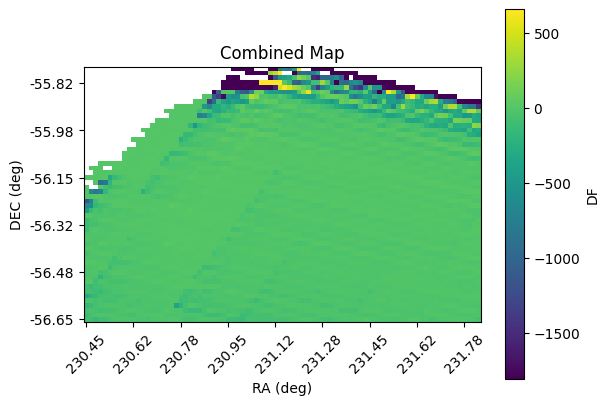

In [28]:
binner = ut.MapBinner(
    timestreams="norm_df",
    source_coords=source_coords,
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res,
    site=BLASTTNG_SITE
)

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

binner.plot()

In [ ]:
grabber = ut.FirstFrameGrabber(frame_type=core.G3FrameType.Calibration)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.add_cal_lamp_df, roach_id=1, iq_key="cal_lamp_data")
pipe.Add(grabber)
pipe.Run()

cal_frame = grabber.first_frame

print(cal_frame)